In [55]:
import json
from datasets import load_dataset
import plotly.express as px
#visualize
import matplotlib.pyplot as plt
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pandas as pd
import nltk
import string
import re
import numpy as np
%matplotlib inline

os.chdir('/Users/jon/Documents/DSDM/term_2/adv_meth_nlp/nlp-final/')

# Data exploration

First load the dataset.

In [56]:
import json
from datasets import load_dataset

# Load the English part of the dataset
train_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='train')
test_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='test')
val_dataset = load_dataset('nlpaueb/multi_eurlex', 'en', split='validation')

Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)
Found cached dataset multi_eurlex (/Users/jon/.cache/huggingface/datasets/nlpaueb___multi_eurlex/en/1.0.0/1addee7110a20c2b01cc3de89456786482e4eea1d2ead0bea3d5383b16cc9fce)


`eurovoc_id` is the ID of a certain area of government activity.

`level` refers to the specificity of a certain topic. For example, european parliament is level 0, quantum computing is level 7.

In [57]:
# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_descriptors.json') as jsonl_file:
    eurovoc_descriptors =  json.load(jsonl_file)

# Get feature map info
train_classlabel = train_dataset.features["labels"].feature
test_classlabel = test_dataset.features["labels"].feature
val_classlabel = val_dataset.features["labels"].feature

# Load (label_id, descriptor) mapping 
with open('./data/eurovoc_concepts.json') as jsonl_file:
    eurovoc_concepts =  json.load(jsonl_file)


Let's take a look at the distribution of labels. 

In [58]:
def get_agg_df(dataset, classlabel):
    df_agg = []
    for i, sample in enumerate(dataset):    
        for label_id in sample['labels']:
            result = {}
            result['celex_id'] = sample['celex_id']
            result['label_id'] = label_id
            result['eurovoc_id'] = classlabel.int2str(label_id)
            result['eurovoc_desc'] = eurovoc_descriptors[classlabel.int2str(label_id)]['en']
            df_agg.append(result)
            # Get the EuroVoc level for the current label ID
            for level, ids in eurovoc_concepts.items():
                if classlabel.int2str(label_id) in ids:
                    result['eurovoc_level'] = level
                    break
    df_agg = pd.DataFrame(df_agg)
    return(df_agg)

train_agg_df = get_agg_df(train_dataset, train_classlabel)
test_agg_df = get_agg_df(test_dataset, test_classlabel)
val_agg_df = get_agg_df(val_dataset, val_classlabel)
df = pd.concat([train_agg_df, test_agg_df, val_agg_df], ignore_index=True)
df['source'] = pd.Series(['train'] * len(train_agg_df) + ['test'] * len(test_agg_df) + ['val'] * len(val_agg_df), dtype='string')

In [59]:
df.head()

,celex_id,label_id,eurovoc_id,eurovoc_desc,eurovoc_level,source
0,32003R1012,2,100148,finance,level_1,train
1,32003R1012,5,100143,international relations,level_1,train
2,32003R1012,10,100142,politics,level_1,train
3,32003R1012,8,100154,transport,level_1,train
4,32003R1012,3,100147,trade,level_1,train


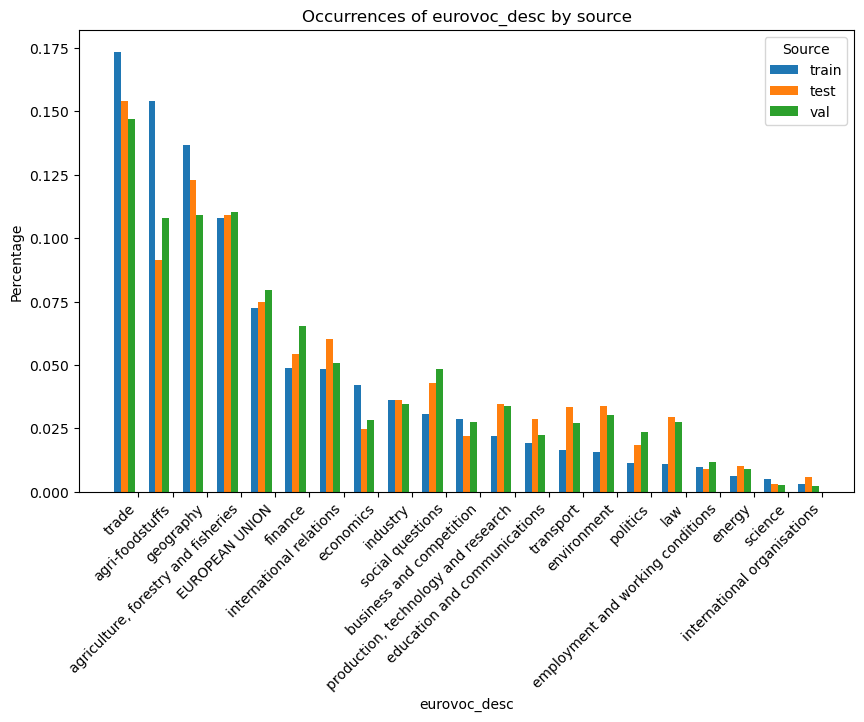

In [60]:

# Group by eurovoc_desc and source, and count occurrences
df_grouped = df.groupby(['eurovoc_desc', 'source']).size().reset_index(name='count')

# Pivot the table to have source as columns and eurovoc_desc as index
df_pivot = df_grouped.pivot_table(index='eurovoc_desc', columns='source', values='count')

# Divide each column by the total count for that source
df_pivot = df_pivot.divide(df_pivot.sum(axis=0), axis=1)

# Sort the pivot table by the train column in descending order
df_pivot = df_pivot.sort_values(by='train', ascending=False)

# Plot a grouped bar chart
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df_pivot))
width = 0.2

ax.bar(x - width, df_pivot['train'], width, label='train')
ax.bar(x, df_pivot['test'], width, label='test')
ax.bar(x + width, df_pivot['val'], width, label='val')

# Set the plot title and axes labels
ax.set_title('Occurrences of eurovoc_desc by source')
ax.set_xlabel('eurovoc_desc')
ax.set_ylabel('Percentage')

# Add a legend to the plot
ax.legend(title='Source', loc='upper right')

# Set the x-axis tick positions and labels
xticks = x - width / 2 + 0.5
ax.set_xticks(xticks)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')

# Show the plot
plt.show()


The only major difference I can see is that agri-foodstuffs is underrepresented in the test set and overrepresented in the training set. 

## Preprocessing

In [61]:
df_train = train_dataset.to_pandas()
df_train.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]"
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]"
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]"
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]"
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]"


In [62]:


# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to preprocess a single document
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers and punctuation using regex
    text = re.sub(r'[^\w\s]', '', re.sub(r'\d+', '', text))

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_words = [word for word in words if word not in stopwords]

    # Stem the remaining words using Porter Stemmer
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Lemmatize the remaining words using WordNetLemmatizer
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    # Join the preprocessed words into a single string
    preprocessed_text = " ".join(lemmatized_words)

    return preprocessed_text

# Preprocess the text in the 'text' column of the DataFrame
df_train['pp_text'] = df_train['text'].apply(preprocess_text)

# Print the preprocessed DataFrame
print(df_train.head())


[nltk_data] Downloading package punkt to /Users/jon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     celex_id                                               text  \
0  32003R1012  Commission Regulation (EC) No 1012/2003\nof 12...   
1  32008R0284  COMMISSION REGULATION (EC) No 284/2008\nof 27 ...   
2  32004D0761  COMMISSION DECISION\nof 26 October 2004\nlayin...   
3  31992R2310  COMMISSION REGULATION (EEC) No 2310/92 of 31 J...   
4  31995R0423  COUNCIL REGULATION (EC) No 423/95 of 20 Februa...   

                     labels                                            pp_text  
0  [2, 5, 10, 8, 3, 18, 15]  commiss regul ec june amend th time council re...  
1            [3, 18, 17, 6]  commiss regul ec march regist certain name reg...  
2       [17, 19, 10, 6, 15]  commiss decis octob lay detail rule applic cou...  
3             [7, 3, 17, 6]  commiss regul eec juli amend regul eec buyingi...  
4               [17, 19, 6]  council regul ec februari amend regul eec lay ...  


In [63]:
df_train.head()

,celex_id,text,labels,pp_text
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,"[2, 5, 10, 8, 3, 18, 15]",commiss regul ec june amend th time council re...
1,32008R0284,COMMISSION REGULATION (EC) No 284/2008\nof 27 ...,"[3, 18, 17, 6]",commiss regul ec march regist certain name reg...
2,32004D0761,COMMISSION DECISION\nof 26 October 2004\nlayin...,"[17, 19, 10, 6, 15]",commiss decis octob lay detail rule applic cou...
3,31992R2310,COMMISSION REGULATION (EEC) No 2310/92 of 31 J...,"[7, 3, 17, 6]",commiss regul eec juli amend regul eec buyingi...
4,31995R0423,COUNCIL REGULATION (EC) No 423/95 of 20 Februa...,"[17, 19, 6]",council regul ec februari amend regul eec lay ...


Now let's look at the most commonly used words and see if there are any words we can add to stop-words

In [64]:
def get_word_freq(df):
    word_counts = df.set_index('celex_id')['pp_text'].str.split()\
        .explode()\
        .reset_index()\
        .drop_duplicates()\
        .groupby('pp_text').size()\
        .sort_values(ascending=False)
    word_counts = word_counts.to_dict()
    word_counts_df = []
    for i, v in word_counts.items():
        result = {}
        result['word'] = i
        result['count'] = v
        word_counts_df.append(result)
    word_counts_df = pd.DataFrame(word_counts_df).sort_values(by='count',ascending=False)
    word_counts_df['pct'] = word_counts_df['count']/len(df_train)
    return word_counts_df
train_wd_ct_df = get_word_freq(df_train)
train_wd_ct_df.head(50)


,word,count,pct
0,european,10998,0.999818
1,regard,10998,0.999818
2,articl,10993,0.999364
3,done,10950,0.995455
4,wherea,10946,0.995091
5,treati,10931,0.993727
6,commun,10903,0.991182
7,particular,10875,0.988636
8,establish,10869,0.988091
9,commiss,10800,0.981818


For now, words that are in >=50% of documents will be added to the list of stop words. 

In [65]:
frequent_words = train_wd_ct_df.loc[train_wd_ct_df['pct'] >= 0.5, 'word'].tolist()
stopwords = set(stopwords.words('english'))
stopwords.update(frequent_words)

def remove_stopwords(text, stopwords=stopwords):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

df_train['pp_text'] = df_train['pp_text'].apply(remove_stopwords)

In [67]:
train_wd_ct_df = get_word_freq(df_train)
train_wd_ct_df.head()

,word,count,pct
0,journal,5498,0.499818
1,concern,5493,0.499364
2,lay,5350,0.486364
3,set,5302,0.482000
4,econom,5257,0.477909


<Figure size 1000x4000 with 0 Axes>

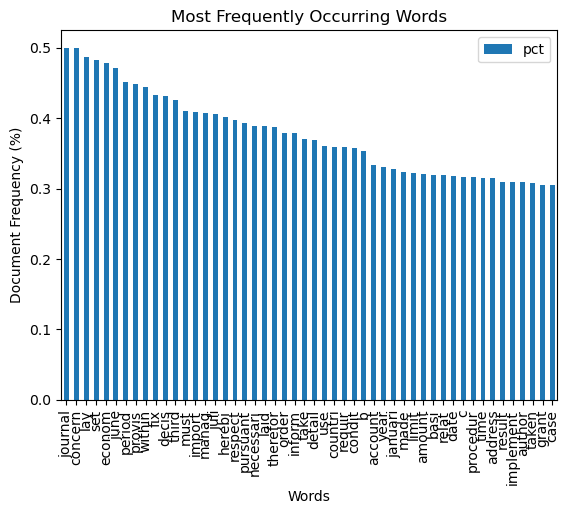

In [78]:

plt.figure(figsize=(10, 40))
train_wd_ct_df.head(50).plot(x='word', y='pct', kind='bar')
plt.xlabel('Words')
plt.ylabel('Document Frequency (%)')
plt.title('Most Frequently Occurring Words')
plt.show()


## Baseline (ie non ML solution) + metrics on test set


As baseline we can take each sentence and get most common words used in the text and predict based on that.

In [10]:
text_only = train_exp.groupby('labels', group_keys=False)['text'].apply(lambda x: x.str.split())

In [11]:
train_exp.head()

,celex_id,text,labels
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,2
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,5
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,10
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,8
0,32003R1012,Commission Regulation (EC) No 1012/2003\nof 12...,3


In [17]:
concepts_df = []
for i, v in eurovoc_concepts.items():
    result = {'concept_id': i, 'label': v['en']}
    concepts_df.append(result)
concepts_df = pd.DataFrame(concepts_df)
concepts_df.head()

,concept_id,label
0,100149,social questions
1,100160,industry
2,100148,finance
3,100147,trade
4,100152,business and competition


In [18]:
concepts_df['label']

NameError: name 'concepts_df' is not defined

In [17]:
from datasets import load_dataset
dataset = load_dataset('nlpaueb/multi_eurlex', 'all_languages')


AttributeError: 'MultiEURLEX' object has no attribute 'languages'

## RNN solution + metrics on test set


## BERT model + metrics on test set